In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
#drive'ı projeye ekleme
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip ./drive/MyDrive/cows/cows.zip > /dev/null

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("cows", {}, "./cows/train/train_coco.json", "./cows/train")

In [5]:
cows_metadata = MetadataCatalog.get("cows")
print(cows_metadata)
dataset_dicts = DatasetCatalog.get("cows")
print(dataset_dicts)


Metadata(evaluator_type='coco', image_root='./cows/train', json_file='./cows/train/train_coco.json', name='cows')
[05/31 11:52:30 d2.data.datasets.coco]: Loaded 57 images in COCO format from ./cows/train/train_coco.json
[{'file_name': './cows/train/1_HolsteinAngusMelez_Back_LiveWeight_419_CarcassWeight_235_01.jpg', 'height': 1280, 'width': 961, 'image_id': 1, 'annotations': [{'iscrowd': 0, 'bbox': [489.0, 3.0, 319.0, 231.0], 'category_id': 0, 'segmentation': [[504.3684210526317, 65.78947368421052, 539.8947368421052, 82.89473684210526, 585.9473684210527, 101.3157894736842, 609.6315789473683, 114.47368421052632, 635.9473684210527, 138.1578947368421, 655.6842105263158, 164.4736842105263, 675.421052631579, 200.0, 700.421052631579, 234.21052631578948, 732.0, 222.3684210526316, 754.3684210526317, 209.21052631578948, 775.421052631579, 202.6315789473684, 795.1578947368421, 196.05263157894737, 793.8421052631579, 161.8421052631579, 783.3157894736842, 136.8421052631579, 766.2105263157894, 121.052

./cows/train/2_HolsteinSimentalMelez_Back_LiveWeight_557_CarcassWeight_323_03.jpg


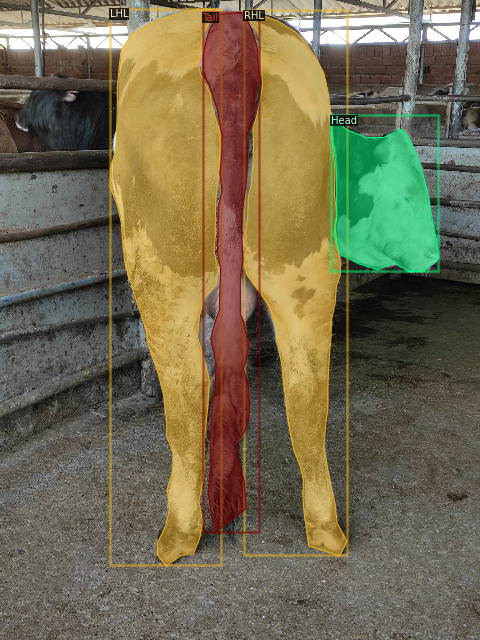

./cows/train/2_HolsteinMelez_Side_LiveWeight_435_CarcassWeight_235_09.jpg


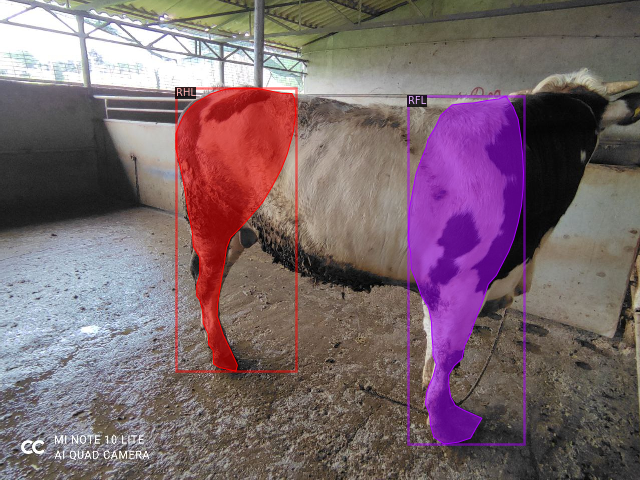

./cows/train/1_HolsteinMelez_Back_LiveWeight_377_CarcassWeight_196_03.jpg


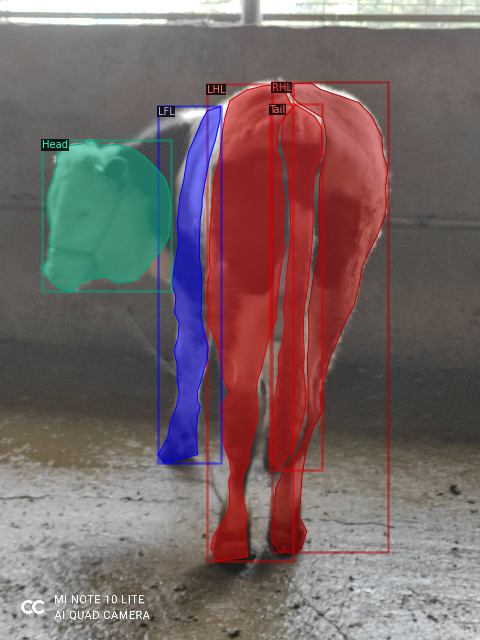

In [6]:
#training setinden örnekler
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cows_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [7]:
#model dosyası alınması
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl -q -O model_final_f10217.pkl


In [8]:
#modelin eğitimi
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cows",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "./model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (300)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # 6 classes 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/31 11:54:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[05/31 11:54:39 d2.engine.train_loop]: Starting training from iteration 0
[05/31 11:55:04 d2.utils.events]:  eta: 0:05:42  iter: 19  total_loss: 3.124  loss_cls: 1.447  loss_box_reg: 0.9707  loss_mask: 0.6901  loss_rpn_cls: 0.07859  loss_rpn_loc: 0.07297  time: 1.2093  data_time: 0.0245  lr: 0.00039962  max_mem: 2335M
[05/31 11:55:28 d2.utils.events]:  eta: 0:05:21  iter: 39  total_loss: 2.524  loss_cls: 0.8166  loss_box_reg: 0.9533  loss_mask: 0.6499  loss_rpn_cls: 0.04168  loss_rpn_loc: 0.0451  time: 1.2182  data_time: 0.0119  lr: 0.00079922  max_mem: 2335M
[05/31 11:55:53 d2.utils.events]:  eta: 0:04:50  iter: 59  total_loss: 2.114  loss_cls: 0.6718  loss_box_reg: 0.9243  loss_mask: 0.4927  loss_rpn_cls: 0.00905  loss_rpn_loc: 0.05941  time: 1.2226  data_time: 0.0116  lr: 0.0011988  max_mem: 2335M
[05/31 11:56:17 d2.utils.events]:  eta: 0:04:26  iter: 79  total_loss: 1.706  loss_cls: 0.514  loss_box_reg: 0.7621  loss_mask: 0.3102  loss_rpn_cls: 0.01366  loss_rpn_loc: 0.05382  time: 

In [10]:
#tahmin nesnesi
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("cows", )
predictor = DefaultPredictor(cfg)


tensor([0, 1, 2, 5, 1], device='cuda:0')
Boxes(tensor([[   2.9527,  100.8653,  471.9546,  473.4626],
        [1094.5255,  157.0815, 1255.8116,  587.5380],
        [ 905.6841,  164.8283, 1147.6505,  960.9999],
        [ 347.5315,  133.2478,  545.2654,  960.9999],
        [1159.1783,  182.1734, 1246.2515,  655.0728]], device='cuda:0'))


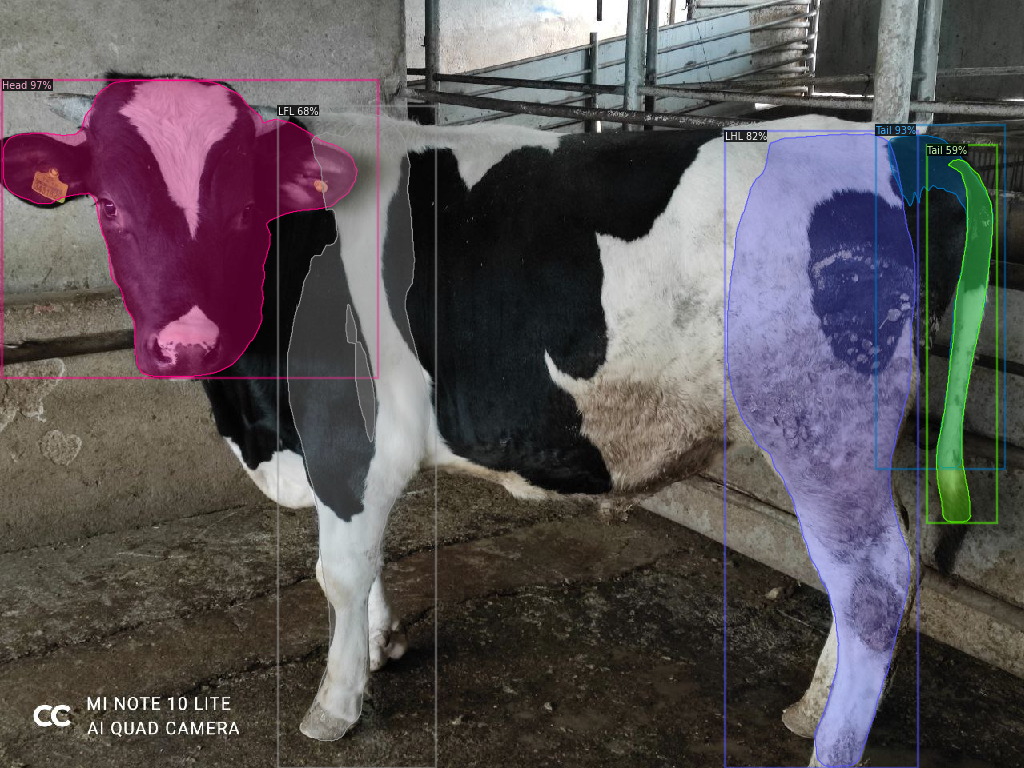

In [14]:
#tahminler
from detectron2.utils.visualizer import ColorMode
im = cv2.imread("./cows/test/2.jpg")
#cv2_imshow(im)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
v = Visualizer(im[:, :, ::-1],
                   metadata=cows_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])